# Análisis de Perfiles de Clientes - Model Fitness

Con el propósito de combatir la cancelación de clientes en Model Fitness, con la información proporcionada por la empresa, se llevará a cabo un análisis de perfiles de clientes, a fin de combatir la cancelación de clientes. 

Por ello, el siguiente proyecto estará dividido en las siguientes etapas: 
1. Carga de datos y librerías
2. Análisis exploratorio de datos
3. Construir un modelo para predecir la cancelación de ususarios
4. Creación de clústeres de usuarios/as
5. Conclusiones y recomendaciones

## Carga de datos y librerías 

En este apartado vamosa incorporar todas las librerías que nos serán de utilidad para el desarrollo del proyecto. 
Asimismo, cargaremos nuestro DataSet 'gym_churn_us'. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df_gym = pd.read_csv('/datasets/gym_churn_us.csv')

## Análisis exploratorio de datos 

En este apartado, a fin de garantizar que los resultados de nuestro modelo sean lo más reales posibles, llevaremos a cabo la siguientes tareas: 
 - Identificación y procesamiento de datos ausentes (en su caso).
 - Estudio de valores promedio y desviación estándar.
 - Identificación de valores medios de las características en dos grupos: las personas que se quedaron y las personas que se fueron.
 - Elaboración de histogramas de barras y distribuciones de características para aquellas personas que se fueron y las que se quedaron.
 - Elaboración de una matriz de correlación. 

### Identificación y procesamiento de datos ausentes (en su caso) y estudio de valores promedio y desviación estándar

In [3]:
print(df_gym.shape)
print(df_gym.head())
df_gym.info() 
print(df_gym.describe())

(4000, 14)
,   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
,0       1              1        1              1      0                6   
,1       0              1        0              0      1               12   
,2       0              1        1              0      1                1   
,3       0              1        1              1      1               12   
,4       1              1        1              1      1                1   
,
,   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
,0             1   29                     14.227470                    5.0   
,1             1   31                    113.202938                   12.0   
,2             0   28                    129.448479                    1.0   
,3             1   33                     62.669863                   12.0   
,4             0   26                    198.362265                    1.0   
,
,   Lifetime  Avg_class_frequency_total  Avg_class_freq

Derivado de esta observación inicial de los datos, podemos identificar las siguientes características relevantes de nuestro set de datos: 
- Está compuesto de 14 características (14 columnas) y 4,000 registros (4,000 filas).
- Tiene valores enteros y flotantes.
- No cuenta con valores ausentes.
- Los valores promedio de las características son muy diferentes, oscilando entre 0.26 (valor mínimo ubicado en la columna 'Churn') y 146.94 (valor máximo ubicado en la columna 'Avg_additional_charges_total')
- Adicionalmente, la desviación estándar también cuenta con valores muy dispersos oscilando entre 0.29 (valor mínimo ubivado en la columna 'Phone') y 96.35 (ubicad en la columna 'Avg_additional_charges_total')

En ese sentido, para facilitar la construcción del modelo, podría ser importante tratar de estandarizar nuestros datos. 

### Identificación de valores medios de las características en dos grupos: las personas que se quedaron y las que se fueron. 

In [4]:
us_por_grupo = df_gym.groupby('Churn')
print(us_por_grupo.mean())

         gender  Near_Location   Partner  Promo_friends     Phone  \
,Churn                                                               
,0      0.510037       0.873086  0.534195       0.353522  0.903709   
,1      0.510839       0.768143  0.355325       0.183789  0.902922   
,
,       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
,Churn                                                                           
,0             5.747193      0.464103  29.976523                    158.445715   
,1             1.728558      0.268615  26.989632                    115.082899   
,
,       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
,Churn                                                               
,0                   5.283089  4.711807                   2.024876   
,1                   1.662582  0.990575                   1.474995   
,
,       Avg_class_frequency_current_month  
,Churn                                     
,0                 

### Elaboración de histogramas de barras y distribuciones de características para aquellas personas que se fueron y las que se quedaron. 

<function matplotlib.pyplot.show(close=None, block=None)>

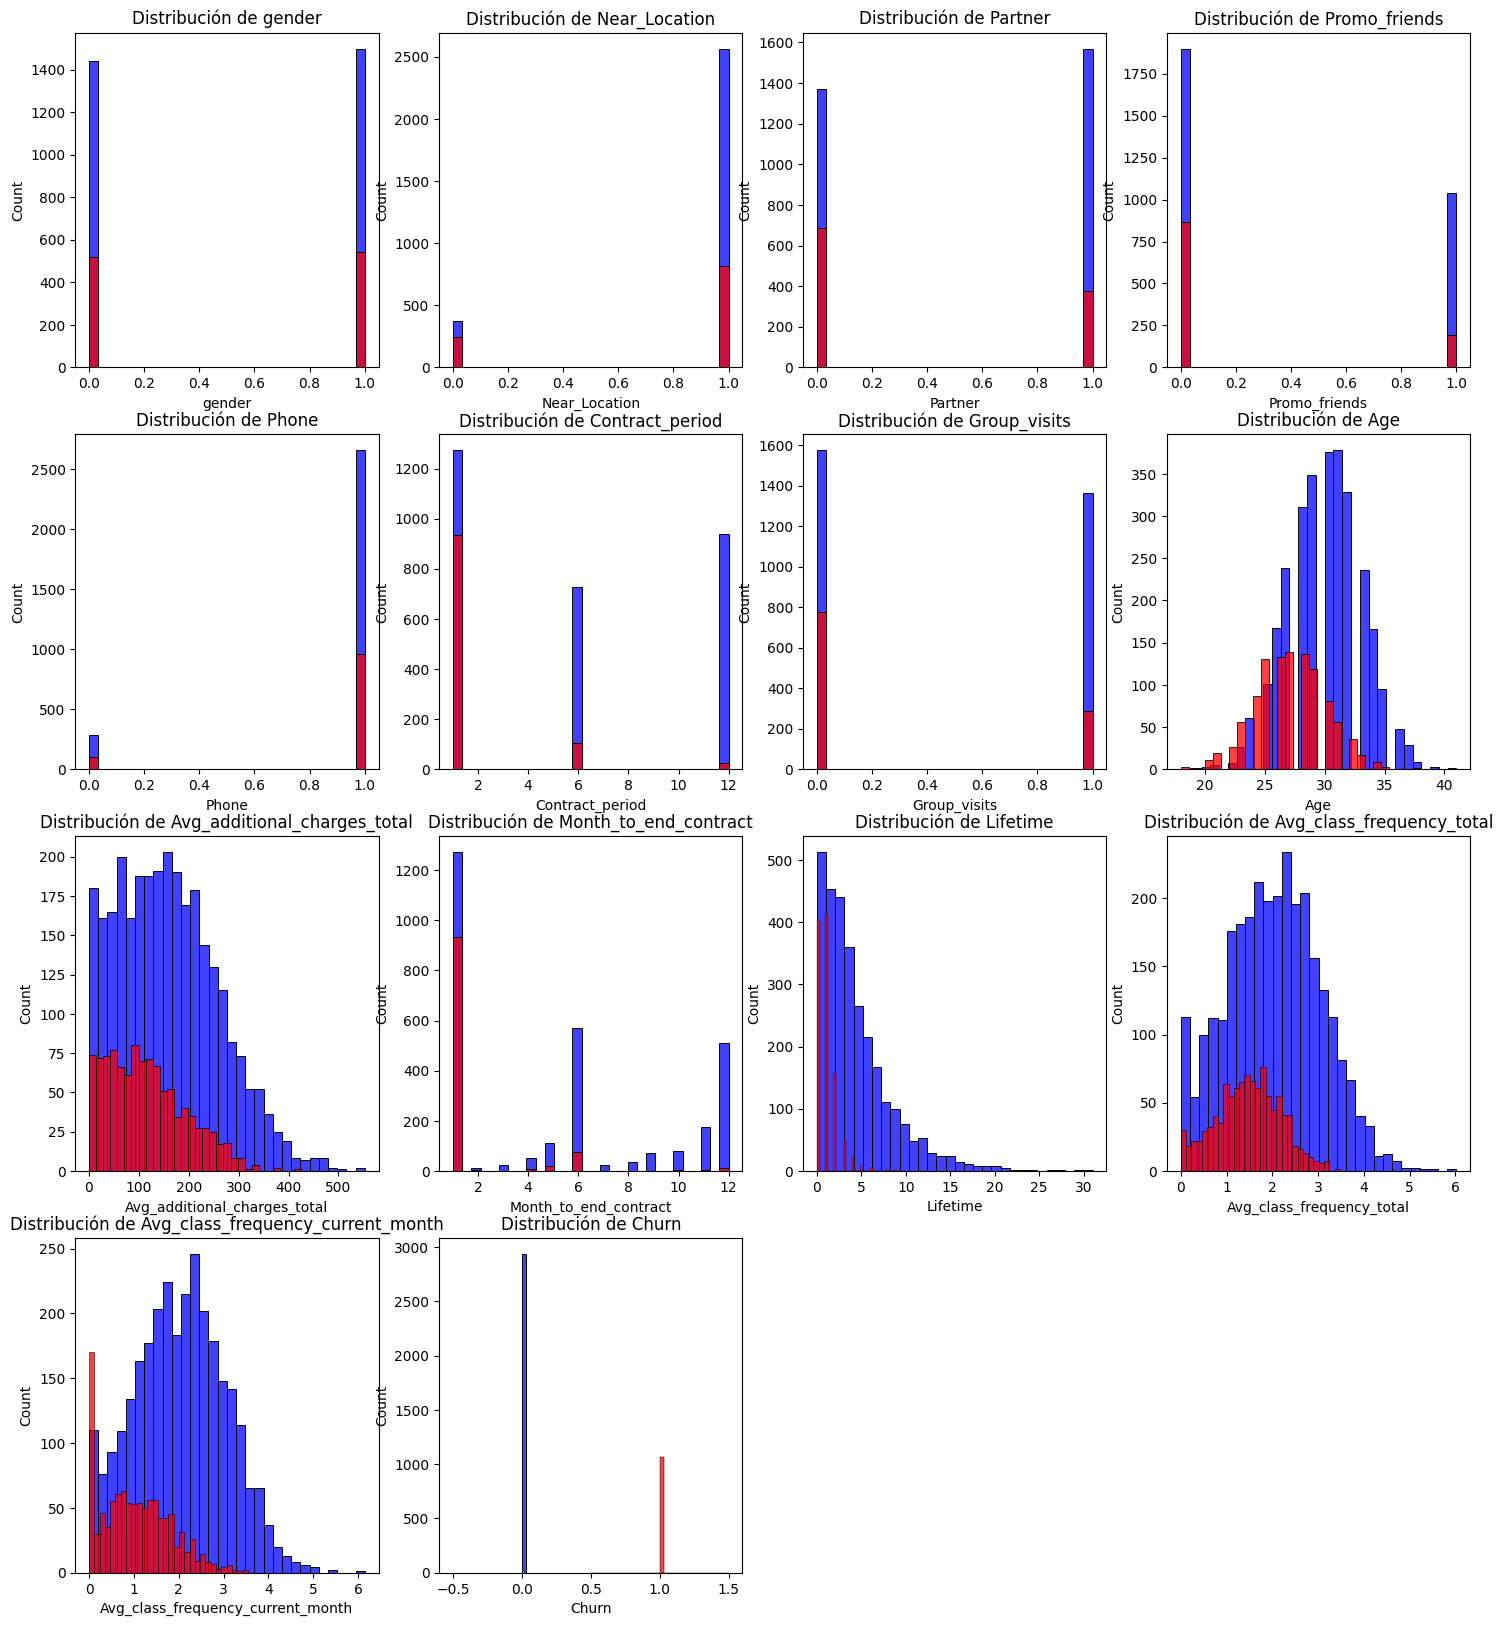

In [5]:
columns = df_gym.columns
plt.figure(figsize=(18,20))
for i, col in enumerate(columns, 1):
    plt.subplot(4,4,i)
    sns.histplot(df_gym[df_gym['Churn']==0][col], color='blue', label='Clientes que se quedaron', bins=30)
    sns.histplot(df_gym[df_gym['Churn']==1][col], color='red', label='Clientes que cancelaron', bins=30)
    plt.title(f'Distribución de {col}')
    plt.legend

plt.show

Derivado del análisis de estos histogramas podemos identificar los siguientes hallazgos para algunas características binarias: 
- Churn: Primero que nada, identificamos que la cantidad de clientes que se fueron no fue tan alta, representa menos de la mitad de los clientes que se quedaron. Sin embargo, se pueden desarrollar estrategias para reducir la cantidad de clientes que se dan de baja. 
- Near_Location: La mayoría de los clientes que se quedaron y que se fueron tenían cerca un gimnasio.
- Partner: La mayoría de los clientes que se quedaron trabajan en una compañía asociada cuyos empleados obtienen descuentos. La mayoría de los clientes que se fueron no trabajan en una de estas compañías. Entonces, podemos suponer que existe cierta relación entre los descuentos ofrecidos y la permanencia o no en el gimnasio.
- Promo_friends: La mayoría de los clientes que se fueron no se inscribieron mediante una oferta "trae a un/a amigo/a". Es decir, no fueron susceptibles a utilizar un código promocional para pagar el primer abono. A diferencia de esto, aproximadamente el 50% y 50% de los clientes que si se quedan ingresaron mediante la oferta y la otra parte sin la oferta. Nuevamente podemos suponer que existe una relación entre los descuentos ofrecidos y la permanencia o no en el gimnasio.


Por otra parte, de las características con datos continuos podemos identificar lo siguiente: 
- Age: La mayoría de los clientes que se quedan tienen entre 30 y 32 años. Mientras que la mayoría de los clientes que se van tienen entre 25 y 30 años.
- Avg_additional_charges_total: Los clientes que se quedan tienden a gastar más en otros servicios ofrecidos en el gimnasio que los clientes que se van.
- Av_class_frequency_current_month: Podemos identificar que a lo largo del mes los clientes que se quedaron visitan entre 1 a 3 veces por semana el gimnasio, mientras que los que se fueron lo visitaban de 0 a 2 veces únicamente.

### Elaboración de una matriz de correlación

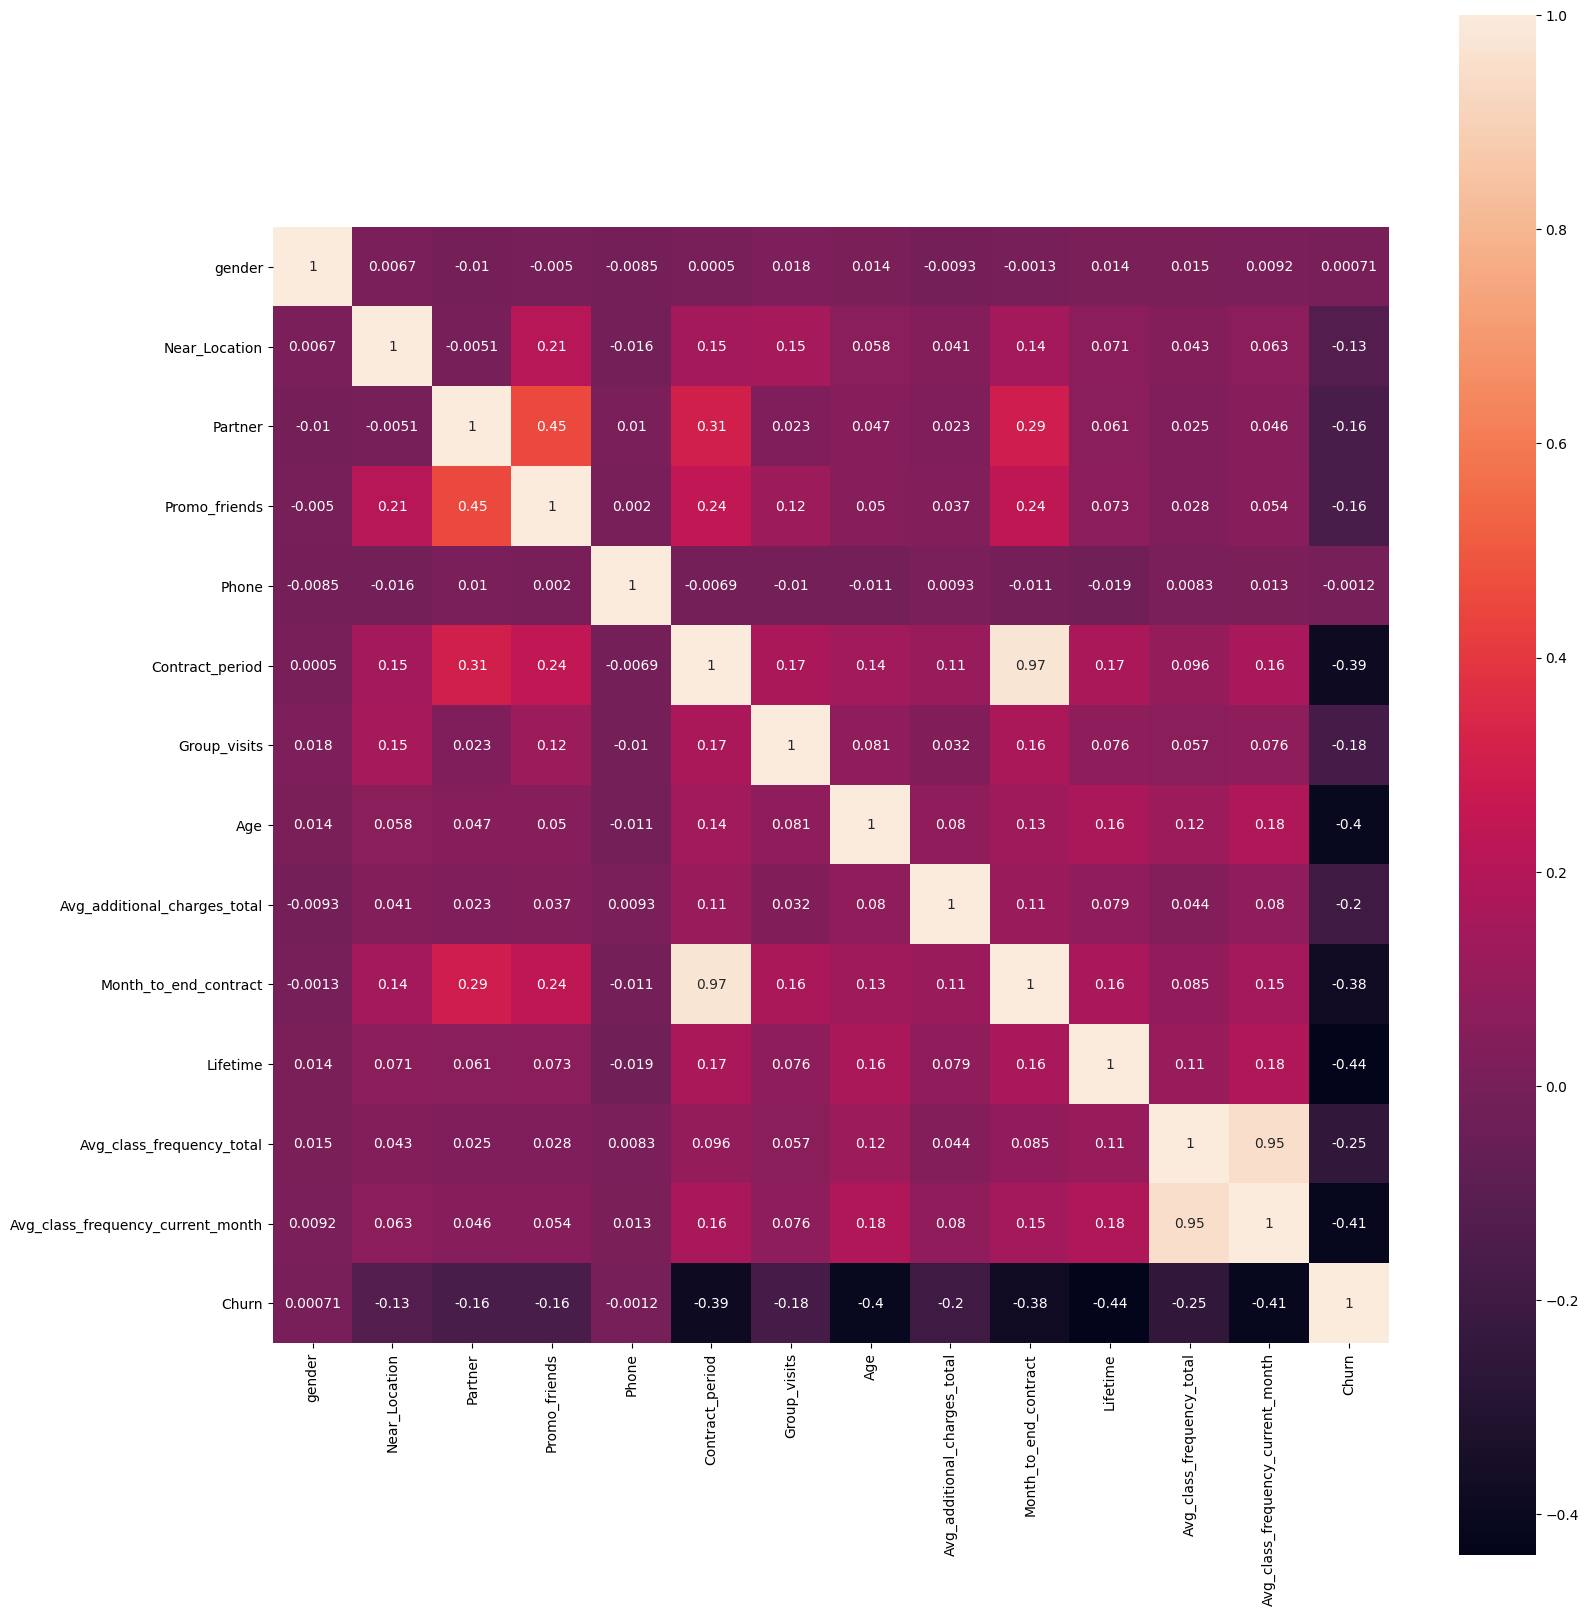

In [6]:
mc = df_gym.corr()
fig, ax = plt.subplots(figsize=(18,20))
sns.heatmap(mc, annot = True, square = True)
plt.show()

Podemos identificar que los pares de características más correlacionados son: 
- Los meses que faltan hasta que expire el contrato y el periodo de contrato (Contract_period y Month_to_end_contract).
- La frecuencia media de visitas por semana durante el mes en curso, y la frecuencia media de visitas por semana a lo largo de la vida del cliente (Av_class_fequency_current_month y Avg_clas_frequency_total) 


## Construcción un modelo para predecir la cancelación de usuarios

En este apartado crearemos un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario o la usuaria en el mes siguiente ('Churn'). 

Para lograr esto, haremos las siguientes tareas: 

- Dividiremos los datos en conjuntos de entrenamiento y validación utilizando la función train_test_split()
- Entrenaremos el modelo en el set de entrenamiento con dos métodos: regresión logística y bosque aleatorio.
- Evaluaremos la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Luego los compararemos para definir qué método dio mejores resultados.

### División de datos en conjuntos de entrenamiento y validación 

Comenzaremos definiendo nuestras variables. Ya que nuestro objetivo es la marcha del usuario o la usuaria, para definir la variable X eliminaremos la columna 'Churn', mientras que para la variable y dicha columna será el valor. 

Posteriormente, estandarizaremos nuestros datos de X para que los resultados de nuestros modelos (específicamente el de regresión logística) sean lo más precisos y exactos posibles. 

In [7]:
X = df_gym.drop('Churn', axis = 1)
y = df_gym['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Entrenamiento del modelo: 

Vamos a entrenar nuestro modelo con dos métodos para determinar cuál nos da mejores resultados: 
- Regresión Logística: ya que es de los modelos más comunes y efectivos para brpblemas de clasificación binaria.
- Bosque aleatorio: que es útil para el análisis cuando las relaciones entre las características son complejas. 

In [8]:
models = [LogisticRegression(), RandomForestClassifier()]

def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Métricas para la predicción automática realizada con predict')
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} F1:{:.2f}'.format(accuracy_score(y_test, y_pred),
                                                              precision_score(y_test, y_pred),
                                                              recall_score(y_test, y_pred),
                                                              f1_score(y_test, y_pred)))

for i in models: 
    print(i)
    make_prediction(m=i, X_train = X_train_st, y_train = y_train, X_test=X_test_st, y_test=y_test)

LogisticRegression()
,Métricas para la predicción automática realizada con predict
,Accuracy:0.92 Precision:0.85 Recall:0.83 F1:0.84
,RandomForestClassifier()
,Métricas para la predicción automática realizada con predict
,Accuracy:0.92 Precision:0.85 Recall:0.81 F1:0.83


### Evaluación de los modelos

En términos generales nuestros modelos tienen calificaciones muy positivas para garantizar que nuestras predicciones son correctas. Sin embargo, toda vez que queremos combatir la cancelación de los usuarios, es indispensable que escojamos el modelo que nos dará mayor presición en cuanto al número posible de usuarios que cancaleran, debemos quedarnos con la regresión logísitca. Lo anterior, en virtud de su recall ligeramente superior. 

## Creación de clusteres de usuarios

Con el propósito de mejorar la retención de clientes llevaremos a cabo un clustering (agrupación de clientes esn segmentos homogéneos basados en sus características y comportamientos similares). Para lograr esto, llevaremos a cabo las siguientes tareas: 
- Utilizaremos la función linkage() para crear una matriz de distancias basada en la matriz de características estandarizados y trazaremos un dendrograma.
- Entrenaremos el modelo de clustering con el algoritmo K-means para predecir los clústeres de clientes.
- Trazaremos distribuciones de características para los clústeres
- Calcularemos la tasa de cancelación para los clústeres.

### Matriz de distancias y trazo del dendrograma

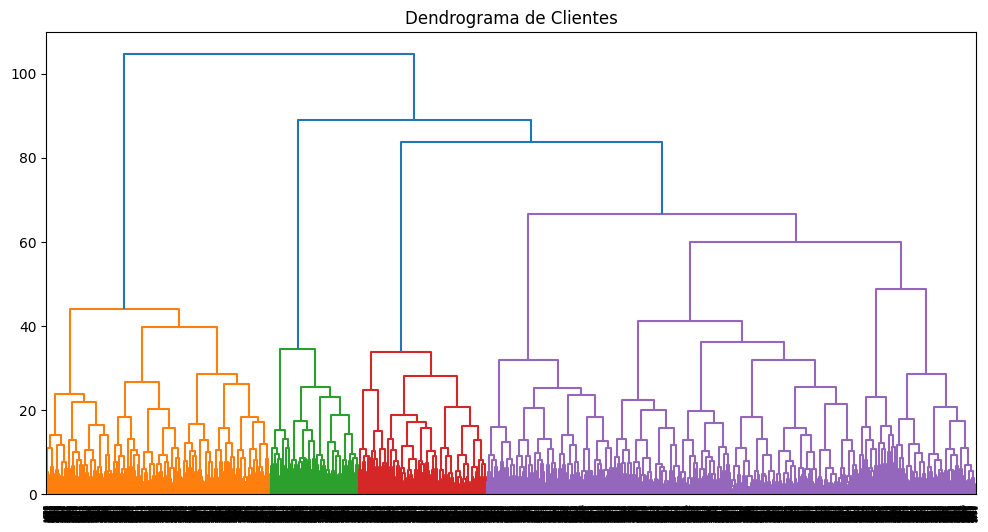

In [9]:
df_clustering = df_gym.drop(columns=['Churn'])
scaler=StandardScaler()
x_sc = scaler.fit_transform(df_clustering)

linked=linkage(x_sc, method = 'ward')

plt.figure(figsize=(12,6))
dendrogram(linked, orientation='top')
plt.title('Dendrograma de Clientes')
plt.show()

Podemos identificar que realmente solo contamos con 5 grandes clusteres.

### Entrenamiento del modelo de clustering con el algoritmo K-means

In [10]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(x_sc)
df_gym['cluster'] = kmeans.labels_

cluster_profiles = df_gym.groupby('cluster').mean().round(2)
display(cluster_profiles)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.0,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.0,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.0,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.0,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.0,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


Podemos identificar los siguientes hallazgos sobre cada cluster: 
- 0: Tiene contratos largos, alta lealtad y alta participación. Son clientes prácticamente leales (solo un 3% de ellos se dio de baja).
- 1: Tiene un perfil intermedio, tiene un porcentaje relativamente bajo de abandono (27%).
- 2: No viven cerca de los gimnasios, pero procuran asistir al gimnasio. Son clientes desconectados y poco leales.
- 3: A pesar de que viven cerca del gimnasio, son los que menos se involucran. Son clientes desmotivados o inactivos y tienen una tendencia de baja del 51%.
- 4: Son los más activos pero tienen contratos cortos. Son clientes nuevos con potencial a quedarse (tienen una tendencia a la baja del 7%).

### Visualizaciones de distribución de las características por clúster

Una vez identificadas las características clave, llevaremos a cabo una visualización de la distribución de las características por clúster, para hacer nuestros hallazgos más visuales. 

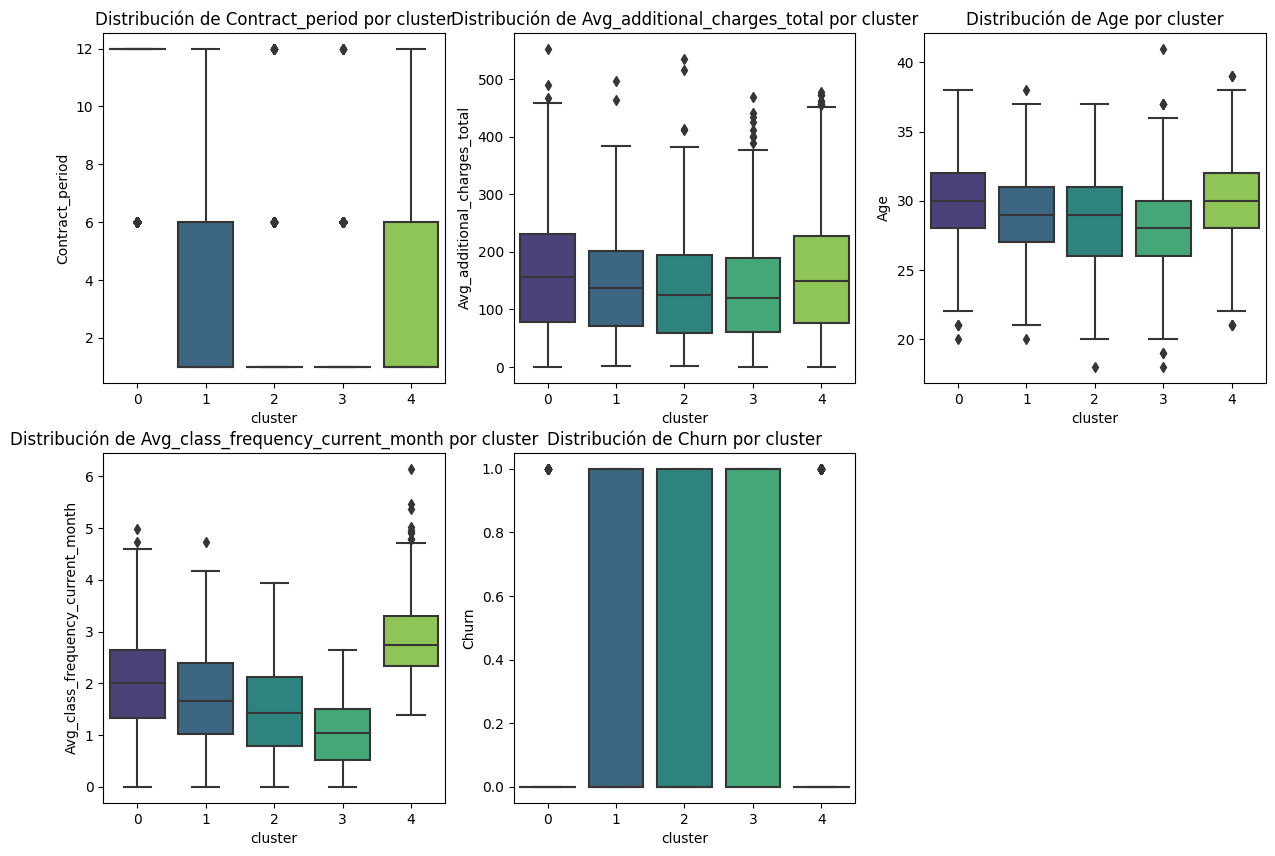

In [11]:
variables = ['Contract_period', 'Avg_additional_charges_total', 'Age', 'Avg_class_frequency_current_month', 'Churn']
plt.figure(figsize=(15,10))
for i, col in enumerate(variables,1):
    plt.subplot(2,3,i)
    sns.boxplot(x='cluster', y=col, data=df_gym, palette='viridis')
    plt.title(f'Distribución de {col} por cluster')
plt.show()

### Cálculo de la tasa de cancelación por clúster

Finalmente, para determinar en qué clúster debemos enfocarnos, calcularemos la tasa de cancelación de cada uno. 

In [12]:
churn_rate = df_gym.groupby('cluster')['Churn'].mean().round(2)
display(churn_rate)

cluster
0    0.03
1    0.27
2    0.44
3    0.51
4    0.07
Name: Churn, dtype: float64

Nuevamente, comprobamos que la tasa de cancelación más alta se encuentra en el tercer clúster. 

## Conclusiones y recomendaciones básicas sobre el trabajo. 

Gracias al presente análisis pudimos identificar que quienes son más propensos a darse de baja del gimnasio son las personas ubicadas en el clúster 3. Clientes que, se inscriben y abandonan rápido. En ese sentido, quizá podrían implementarse las siguientes medidas para incrementar la retención de dicho clúster: 
- Podemos hacer encuestas para determinar los motivos de abandono (ya que esto puede ser por el precio, por la calidad de los servicios ofrecidos o por los mismos horarios del gimnasio).
- Adicionalmente, podemos hacer programas de seguimiento personalizado los primeros dos meses, brindando un acompañamiento de entrenamientos iniciales guiados.

Es importante mencionar, que las personas ubicadas en el clúster 2 también son altamente propensas al abandono. Dentro de este clúster encontramos a clientes que parecen estar desmotivados o inactivos. En ese sentido, si quisiéramos aumentar la retención de este clúster, podemos hacer lo siguiente: 
- Primero, debemos evaluar si vale la pena retenerlos, es decir si esos clientes pueden convertirse en leales o frecuentes.
- Si determinamos que si pueden serlo, podemos implementar campañas de reenganche, como descuentos o pruebas gratuitas.

Indudablemente, la ejecución de este ejercicio crucial para entender el comportamiento de nuestros clientes, con el propósito de mejorar la retención de estos. 